In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
#Constants
alpha = 0.01
mu_0 = 1.25663706212*(10**(-6))
gamma = 1.76085963023*(10**11)
H = [0,0,10

In [3]:
def eq1(x, y): 
    return ((x - y)/2) 

# A sample differential equation "dy/dx = -y" 
def eq2(x, y): 
    return (-y) 

# differential equation for precision term of LLGS" 
def eq3(t, H):
    return -(gamma*mu_0)/(1+alpha**2)*np.cross(M,H)
    
# # Finds value of y for a given x using step size h 
# # and initial value y0 at x0. 
def rungeKuttaNew(diff_eq, x_n, y_n, x, h): 
    y = y_n 
    n = int((x - x_n)/h) 
    # Iterate for n number of iterations 
    for i in range(1, n + 1): 
        "Apply Runge Kutta Formulas to find next value of y"
        k1 = h * diff_eq(x_n, y) 
        k2 = h * diff_eq(x_n + 0.5*h, y + 0.5*k1*h) 
        k3 = h * diff_eq(x_n + 0.5*h, y + 0.5*k2*h) 
        k4 = h * diff_eq(x_n + h, y + k3*h) 
        # Update next value of y 
        y = y + (1.0 / 6.0)*(k1 + 2*k2 + 2*k3 + k4) 
        # Update next value of x 
        x_n = x_n + h 
    return y 

def rungeKutta(diff_eq, x_n, y_n, x, h): 
    y = y_n 
    n = int((x - x_n)/h) 
    # Iterate for n number of iterations 
    for i in range(1, n + 1): 
        "Apply Runge Kutta Formulas to find next value of y"
        k1 = h * diff_eq(x_n, y) 
        k2 = h * diff_eq(x_n + 0.5*h, y + 0.5*k1) 
        k3 = h * diff_eq(x_n + 0.5*h, y + 0.5*k2) 
        k4 = h * diff_eq(x_n + h, y + k3) 
        # Update next value of y 
        y = y + (1.0 / 6.0)*(k1 + 2*k2 + 2*k3 + k4) 
        # Update next value of x 
        x_n = x_n + h 
    return y 

In [4]:
# Test 1  
x0 = 0
y0 = 1
x = 2
h_list = [2, 1, 0.8, 0.5, 0.2, 0.1, 0.001, 10**(-3)]
print("Using differential equation dy/dx = (x - y)/2")
for h in h_list:
    ans = rungeKuttaNew(eq1, x0, y0, x, h)
    print('when h = {} the value of y at x is:{}'.format(str(h),ans))
    print('accuracy = {}'.format(((1.605551275-ans)/1.605551275)*100))


Using differential equation dy/dx = (x - y)/2
when h = 2 the value of y at x is:1.3333333333333333
accuracy = 16.954795895052733
when h = 1 the value of y at x is:1.1045125325520833
accuracy = 31.20664847330502
when h = 0.8 the value of y at x is:0.945626032246329
accuracy = 41.10271985886412
when h = 0.5 the value of y at x is:1.1113393521694261
accuracy = 30.7814475019226
when h = 0.2 the value of y at x is:1.1096073229170962
accuracy = 30.889325044004206
when h = 0.1 the value of y at x is:1.1071364573357978
accuracy = 31.04322019639032
when h = 0.001 the value of y at x is:1.1036784225644738
accuracy = 31.258600098930273
when h = 0.001 the value of y at x is:1.1036784225644738
accuracy = 31.258600098930273


In [5]:
# Test 2  
x0 = 0
y0 = 1
x = 5
h_list = [2, 1, 0.8, 0.5, 0.2, 0.1 , 10**(-3)]
print("Using differential equation new dy/dx = -y")
for h in h_list:
    ans = rungeKuttaNew(eq2, x0, y0, x, h)
    print('when h = {} the value of y at x is:{}'.format(str(h),ans))
    print('accuracy = {}'.format(((0.367879-ans)/0.367879)*100))

Using differential equation new dy/dx = -y
when h = 2 the value of y at x is:9.0
accuracy = -2346.4565794731416
when h = 1 the value of y at x is:0.007415771484375
accuracy = 97.98418189557572
when h = 0.8 the value of y at x is:0.004758786157711907
accuracy = 98.70642625490666
when h = 0.5 the value of y at x is:0.0029064410317486957
accuracy = 99.20994646833641
when h = 0.2 the value of y at x is:0.004272560041601913
accuracy = 98.83859637500322
when h = 0.1 the value of y at x is:0.005298412517877426
accuracy = 98.55974042609732
when h = 0.001 the value of y at x is:0.006721128779480543
accuracy = 98.17300558621706


### Test with dy/dx=-y

In [6]:
# Test Debasis
x_axis = np.linspace(0,8,100)
y_anal = np.exp(-x_axis)
y_rk4 = []

for x in x_axis:
    y_rk4.append(rungeKuttaNew(eq2, 0, 1, x, 0.08))
    

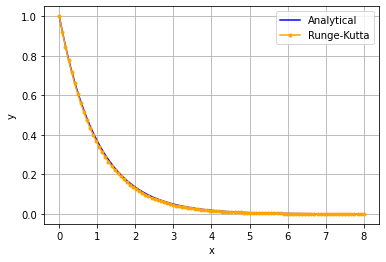

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(x_axis, y_anal, 'b', label='Analytical')
plt.plot(x_axis, y_rk4, 'orange', marker=".", label='Runge-Kutta')

plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='upper right')
plt.grid()

plt.show()

### Test with precision term of LLGS

In [8]:
t_axis = np.linspace(0,8*10^(-7),100)

h = 8*(10**(-9))
m_0 = [0, 1/2, math.sqrt(1-(1/2)**2)]

# #analytical solution
# m_anal = []
# for t in t_axis:
#     m_anal_res = np.exp(-(gamma*mu_0)/(1+alpha**2)*t*H)
#     m_anal.append(m_anal_res)
#     print(m_anal_res)

In [ ]:
# RK4 solution
m_rk4 = []
m_prev = m_0
t_prev = 0
for t in t_axis:
    print(t_prev)
    print(m_prev)
#     import pdb; pdb.set_trace()
    new_m = rungeKutta(eq3, t_prev, m_prev, t, h)
    m_rk4.append(new_m)
    m_prev = new_m
    t_prev = t

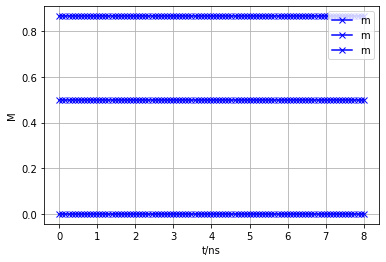

In [167]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plt.plot(x_axis, m_anal, label='Analytical')
plt.plot(x_axis, m_rk4, 'xb-', label='m')

plt.xlabel("t/ns")
plt.ylabel("M")
plt.legend(loc='upper right')
plt.grid()

plt.show()